In [421]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.impute import SimpleImputer,KNNImputer
from sklearn.preprocessing import StandardScaler, MinMaxScaler
from sklearn.model_selection import train_test_split,GridSearchCV
from sklearn.ensemble import AdaBoostClassifier

In [422]:
pd.set_option('display.max_rows', None)
pd.set_option('display.max_columns', None)

file_path = "./TrainDataset2024.xls"
df = pd.read_excel(file_path)
print(df.info())
print(df.describe())

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 400 entries, 0 to 399
Columns: 121 entries, ID to original_ngtdm_Strength
dtypes: float64(108), int64(12), object(1)
memory usage: 378.2+ KB
None
       pCR (outcome)  RelapseFreeSurvival (outcome)         Age          ER  \
count     400.000000                     400.000000  400.000000  400.000000   
mean       12.697500                      56.000208   51.804674    0.547500   
std       111.107417                      27.137584   10.948522    0.498362   
min         0.000000                       0.000000   23.000000    0.000000   
25%         0.000000                      38.000000   44.516769    0.000000   
50%         0.000000                      55.000000   51.019507    1.000000   
75%         0.000000                      73.000000   60.000000    1.000000   
max       999.000000                     144.000000   79.603012    1.000000   

              PgR        HER2  TrippleNegative  ChemoGrade  Proliferation  \
count  400.0000

In [423]:
# Step 1: missing values
# replace 999 with NaN
df.replace(999, np.nan, inplace=True)
print(df.isnull().sum())

# Imputation of Gene
print(f"Ratio of missing value in Gene is {df['Gene'].isnull().sum() / df['Gene'].count()}")
df['Gene'] = df['Gene'].fillna(-1)

# Make sure no missing in pCR
df = df[df['pCR (outcome)'].isin([0, 1])]
# Drop RFS
df.drop(columns="RelapseFreeSurvival (outcome)",inplace=True)

# Categorical imputation
categorical_features = ['ER', 'PgR','HER2', 'TrippleNegative', 'ChemoGrade','Proliferation','HistologyType','LNStatus','TumourStage', 'Gene']
imputer_cat = SimpleImputer(strategy='most_frequent')
df[categorical_features] = imputer_cat.fit_transform(df[categorical_features])

# Numerical Imputation
numerical_features = [col for col in df.columns if col not in categorical_features + ['ID', 'pCR (outcome)']]
imputer_num = KNNImputer(n_neighbors=5)
df[numerical_features] = imputer_num.fit_transform(df[numerical_features])

# Check imbalance 
print(f"Ratio of '1' in pCR is {(df['pCR (outcome)']==1).sum() / df['pCR (outcome)'].count()}")

ID                                                     0
pCR (outcome)                                          5
RelapseFreeSurvival (outcome)                          0
Age                                                    0
ER                                                     0
PgR                                                    1
HER2                                                   1
TrippleNegative                                        1
ChemoGrade                                             3
Proliferation                                          2
HistologyType                                          3
LNStatus                                               1
TumourStage                                            0
Gene                                                  88
original_shape_Elongation                              0
original_shape_Flatness                                0
original_shape_LeastAxisLength                         0
original_shape_MajorAxisLength 

In [424]:
from sklearn.impute import KNNImputer

# Step 2: Outliers
for col in numerical_features:
    q1 = df[col].quantile(0.20)
    q3 = df[col].quantile(0.80)
    iqr = q3 - q1
    lower_bound = q1 - 1.5 * iqr
    upper_bound = q3 + 1.5 * iqr
    df[col] = np.where(df[col] < lower_bound, lower_bound, df[col])
    df[col] = np.where(df[col] > upper_bound, upper_bound, df[col])
    
# Step 3: Data Standardization
scaler = StandardScaler()
df[numerical_features] = scaler.fit_transform(df[numerical_features])

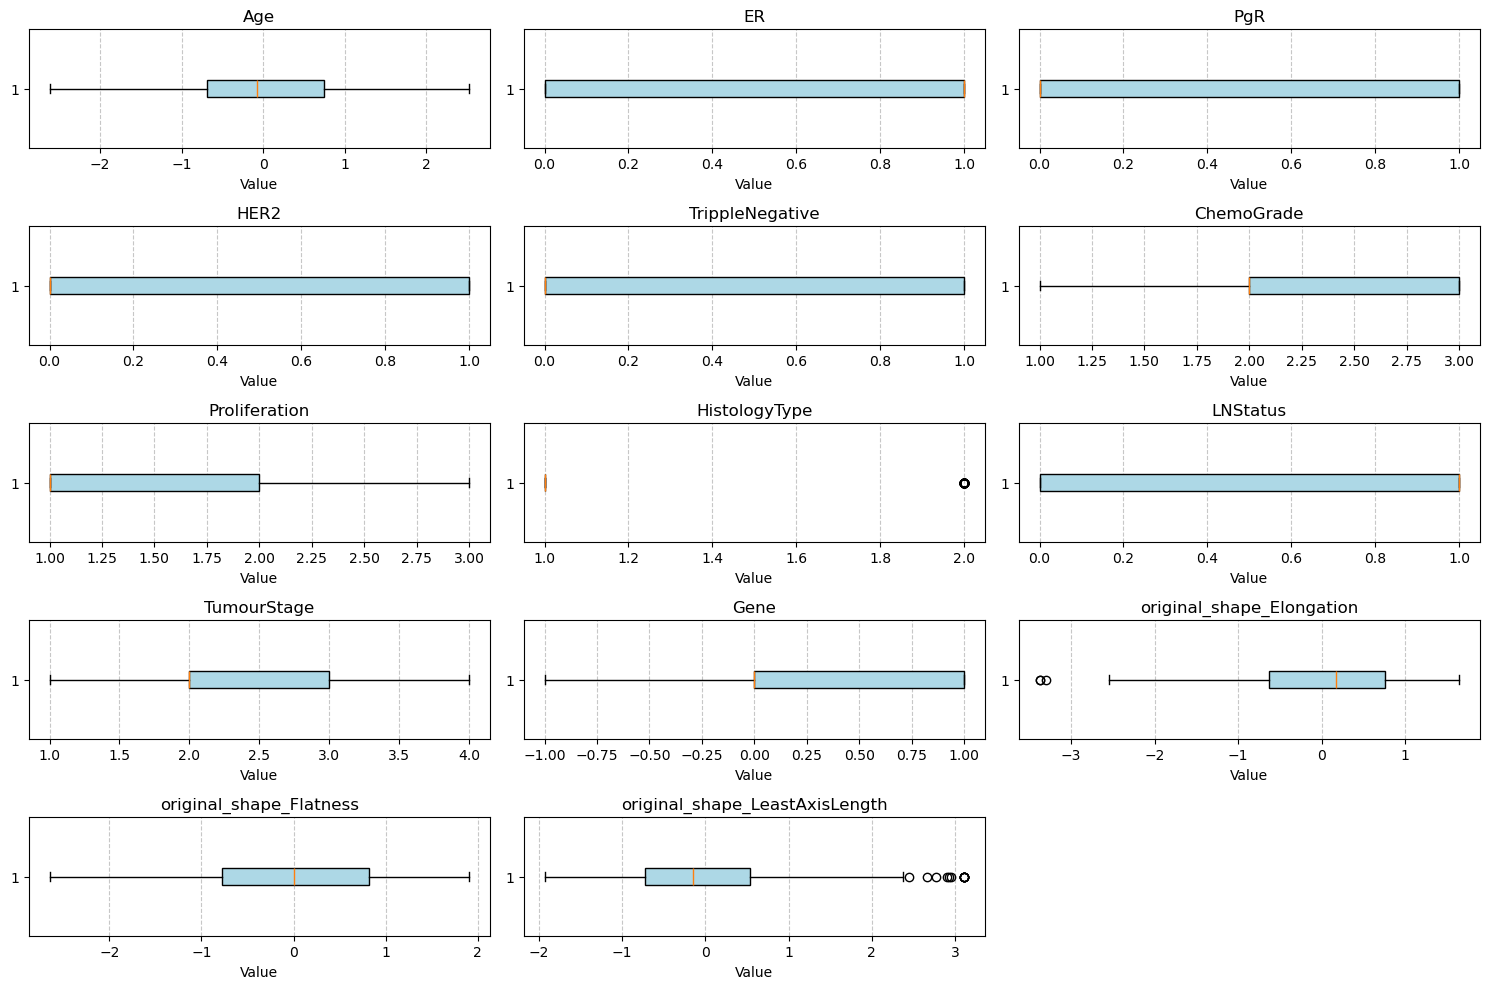

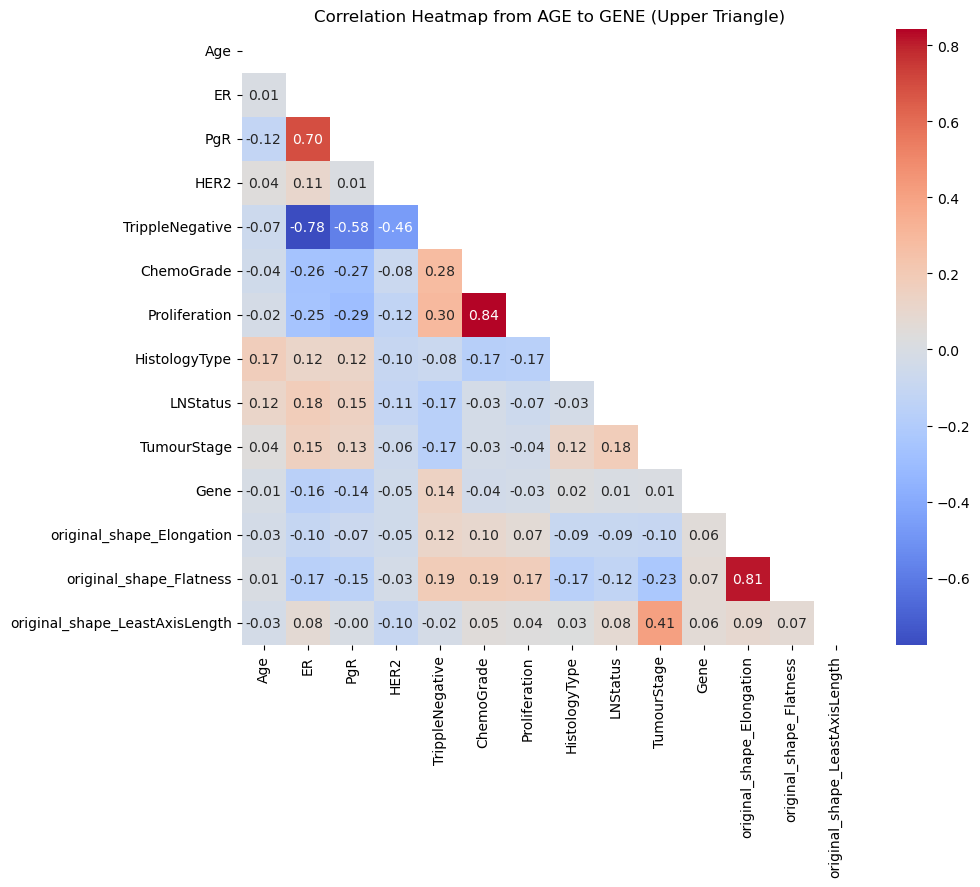

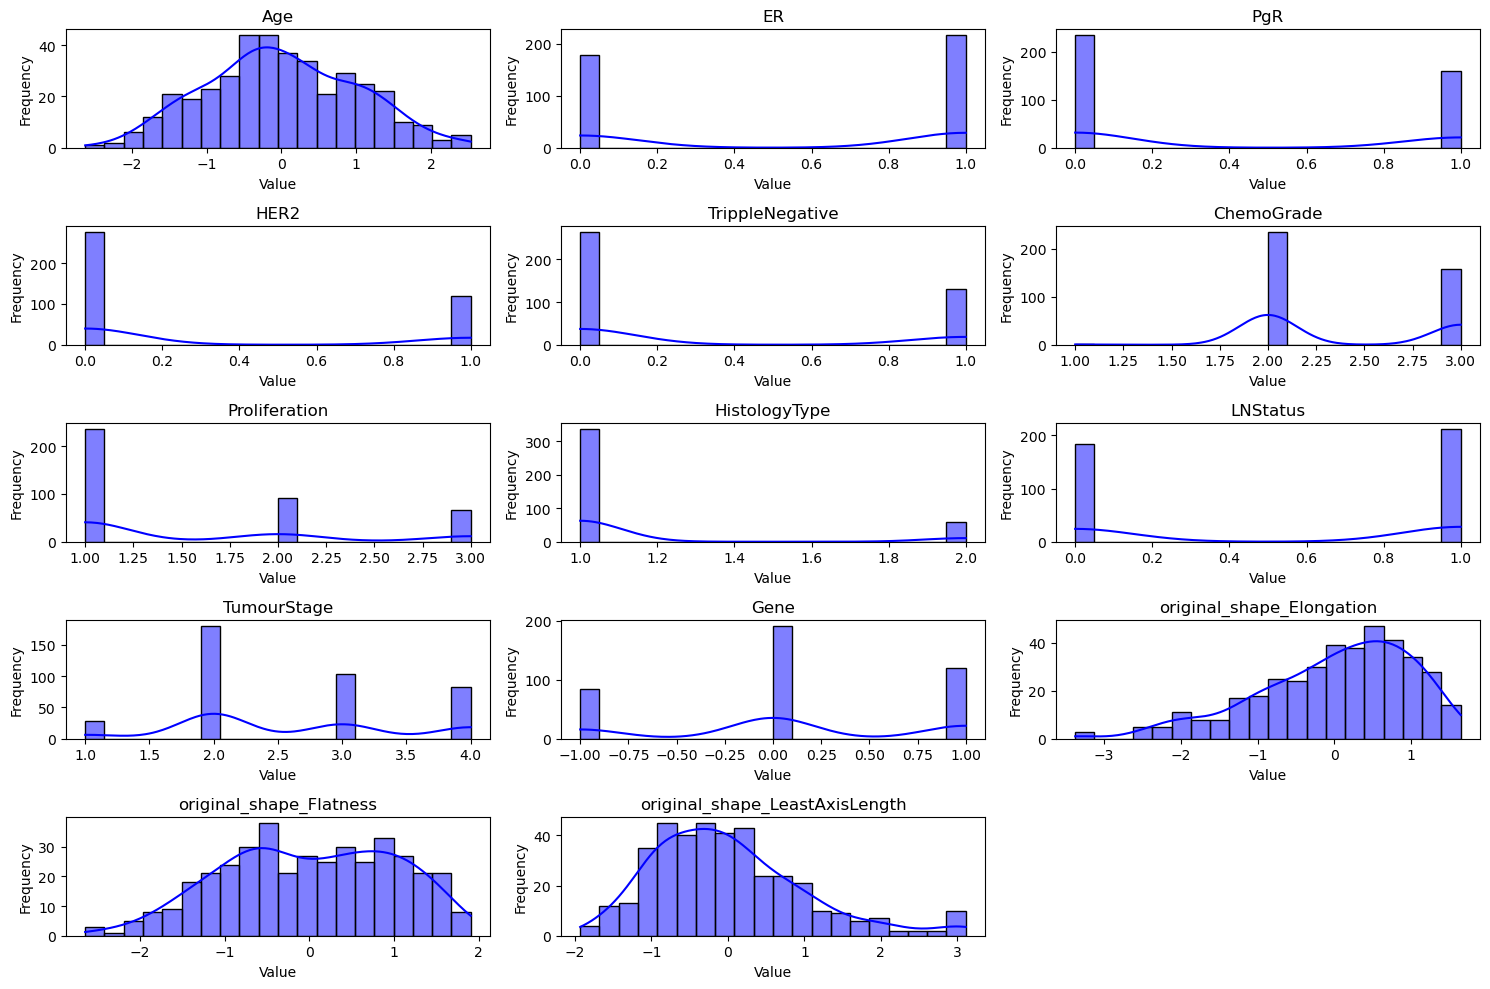

In [425]:
# from AGE to GENE
selected_columns = df.loc[:, 'Age':'original_shape_LeastAxisLength']

# Step 1: 绘制箱线图
plt.figure(figsize=(15, 10))
for i, col in enumerate(selected_columns.columns):
    plt.subplot((len(selected_columns.columns) + 2) // 3, 3, i + 1)  # 动态布局
    plt.boxplot(selected_columns[col].dropna(), vert=False, patch_artist=True, boxprops=dict(facecolor='lightblue'))
    plt.title(col)
    plt.xlabel('Value')
    plt.grid(axis='x', linestyle='--', alpha=0.7)

plt.tight_layout()
plt.show()

# Step 2: 绘制相关性热图
# 计算相关性矩阵
corr_matrix = selected_columns.corr()
# 使用 Seaborn 绘制热成像分布图
plt.figure(figsize=(10, 8))
# 创建掩码
mask = np.triu(np.ones_like(corr_matrix, dtype=bool))
# 使用 Seaborn 绘制热成像分布图（仅上三角）
sns.heatmap(corr_matrix, mask=mask, annot=True, fmt=".2f", cmap="coolwarm", cbar=True, square=True)
plt.title("Correlation Heatmap from AGE to GENE (Upper Triangle)")
plt.show()
# Step 3: 绘制直方图
plt.figure(figsize=(15, 10))
for i, col in enumerate(selected_columns.columns):
    plt.subplot((len(selected_columns.columns) + 2) // 3, 3, i + 1)  # 动态布局
    sns.histplot(selected_columns[col], kde=True, color='blue', bins=20)
    plt.title(col)
    plt.xlabel('Value')
    plt.ylabel('Frequency')
plt.tight_layout()
plt.show()

In [426]:
# Step 4: Splitting Data
X = df.drop(columns=['ID', 'pCR (outcome)']) 
y = df['pCR (outcome)']

# 按 8:2 splitting with stratified
X_train, X_val, y_train, y_val = train_test_split(
    X, y, test_size=0.2, random_state=42, stratify=y
)

In [427]:
# SMOTE
from imblearn.over_sampling import SMOTENC

smote = SMOTENC(categorical_features = categorical_features, random_state=42)
X_train_resampled, y_train_resampled = smote.fit_resample(X_train, y_train)
print("Class distribution after SMOTE:", np.bincount(y_train_resampled))

# Step 5: 检查处理结果
print("PCR 训练集:", X_train_resampled.shape, "验证集:", X_val.shape)

Class distribution after SMOTE: [249 249]
PCR 训练集: (498, 118) 验证集: (79, 118)


C:\Users\22519\AppData\Local\Temp\ipykernel_14664\3778971714.py:6: DeprecationWarning: Non-integer input passed to bincount. In a future version of NumPy, this will be an error. (Deprecated NumPy 2.1)
  print("Class distribution after SMOTE:", np.bincount(y_train_resampled))


In [428]:
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, roc_auc_score
from sklearn.metrics import roc_curve,precision_recall_curve,balanced_accuracy_score
from sklearn.model_selection import KFold
import numpy as np
from sklearn.metrics import classification_report

# Performance evaluation
def evaluate_model(model,y_val,y_pred):
    print(model)
    print(classification_report(y_val, y_pred))
    # Metrics
    b_accuracy = balanced_accuracy_score(y_val,y_pred)
    accuracy = accuracy_score(y_val, y_pred)
    precision = precision_score(y_val, y_pred)
    recall = recall_score(y_val, y_pred)
    f1 = f1_score(y_val, y_pred)
    roc_auc = roc_auc_score(y_val, y_pred)

    
    # Display Metrics
    print(f"Blanced Accuracy: {b_accuracy:.4f}")
    print(f"Accuracy: {accuracy:.4f}")
    print(f"Precision: {precision:.4f}")
    print(f"Recall: {recall:.4f}")
    print(f"F1-Score: {f1:.4f}")
    print(f"ROC-AUC: {roc_auc:.4f}")

# thershold tuning curve
def precision_recall_graph(y_probs):
    thresholds = np.arange(0.1, 1.0, 0.1)
    for threshold in thresholds:
        y_pred = (y_probs >= threshold).astype(int)  # Convert probabilities to binary predictions
        precision = precision_score(y_val, y_pred)
        recall = recall_score(y_val, y_pred)
        f1 = f1_score(y_val, y_pred)
        print(f"Threshold: {threshold:.1f}, Precision: {precision:.2f}, Recall: {recall:.2f}, F1: {f1:.2f}")

    # Get precision, recall, and thresholds
    precision, recall, thresholds = precision_recall_curve(y_val, y_probs)

    # Plot the curve
    plt.plot(thresholds, precision[:-1], label='Precision')
    plt.plot(thresholds, recall[:-1], label='Recall')
    plt.xlabel('Threshold')
    plt.ylabel('Score')
    plt.legend(loc='best')
    plt.title('Precision-Recall vs. Threshold')
    plt.show()

    best_threshold = 0
    best_f1 = 0
    for threshold in thresholds:
        y_pred = (y_probs >= threshold).astype(int)
        f1 = f1_score(y_val, y_pred)
        if f1 > best_f1:
            best_f1 = f1
            best_threshold = threshold

    print(f"Best Threshold: {best_threshold}, Best F1-Score: {best_f1}")

    # Get false positive rate (fpr), true positive rate (tpr), and thresholds
    fpr, tpr, thresholds = roc_curve(y_val, y_probs)

    # Compute Youden's J statistic
    j_scores = tpr - fpr
    best_threshold = thresholds[np.argmax(j_scores)]
    print(f"Best Threshold (Youden's J): {best_threshold}")       

In [429]:
# Step 6: Build Baseline Models
from sklearn.ensemble import RandomForestClassifier
from sklearn.linear_model import LogisticRegression

print("----Before SMOTE----")

# Model 0-1: LogisticRegression
baseline_lr = LogisticRegression(max_iter = 500,random_state=42)
baseline_lr.fit(X_train, y_train)
print("\nLogistic Regression - Classification Report:")
print(classification_report(y_val, baseline_lr.predict(X_val)))

# Model 0-2: RandomForestClassifier
baseline_rf = RandomForestClassifier(random_state=42)
baseline_rf.fit(X_train, y_train)
print("\nRandom Forest- Classification Report:")
print(classification_report(y_val, baseline_rf.predict(X_val)))

print("----After SMOTE----")

# Model 1: LogisticRegression
baseline_lr = LogisticRegression(max_iter = 500,random_state=42)
baseline_lr.fit(X_train_resampled, y_train_resampled)
print("\nLogistic Regression - Classification Report:")
print(classification_report(y_val, baseline_lr.predict(X_val)))

# Model 2: RandomForestClassifier
baseline_rf = RandomForestClassifier(random_state=42)
baseline_rf.fit(X_train_resampled, y_train_resampled)
print("\nRandom Forest- Classification Report:")
print(classification_report(y_val, baseline_rf.predict(X_val)))

----Before SMOTE----

Logistic Regression - Classification Report:
              precision    recall  f1-score   support

         0.0       0.79      0.90      0.84        62
         1.0       0.25      0.12      0.16        17

    accuracy                           0.73        79
   macro avg       0.52      0.51      0.50        79
weighted avg       0.67      0.73      0.70        79


Random Forest- Classification Report:
              precision    recall  f1-score   support

         0.0       0.81      0.95      0.87        62
         1.0       0.50      0.18      0.26        17

    accuracy                           0.78        79
   macro avg       0.65      0.56      0.57        79
weighted avg       0.74      0.78      0.74        79

----After SMOTE----

Logistic Regression - Classification Report:
              precision    recall  f1-score   support

         0.0       0.81      0.77      0.79        62
         1.0       0.30      0.35      0.32        17

    accura

In [430]:
from sklearn.model_selection import cross_val_score, KFold

# Step 7: Building models
# Model 1: RandomForestClassifier
rf = RandomForestClassifier(class_weight='balanced', n_estimators=75,random_state=42)
rf.fit(X_train_resampled, y_train_resampled)
rf_y_pred = rf.predict(X_val)
evaluate_model(rf,y_val,rf_y_pred)

# Feature importances
importances = rf.feature_importances_
feature_importances = pd.DataFrame({'Feature': X.columns, 'Importance': importances})
feature_importances = feature_importances.sort_values(by='Importance', ascending=False)
print(feature_importances)

RandomForestClassifier(class_weight='balanced', n_estimators=75,
                       random_state=42)
              precision    recall  f1-score   support

         0.0       0.81      0.92      0.86        62
         1.0       0.44      0.24      0.31        17

    accuracy                           0.77        79
   macro avg       0.63      0.58      0.59        79
weighted avg       0.73      0.77      0.74        79

Blanced Accuracy: 0.5773
Accuracy: 0.7722
Precision: 0.4444
Recall: 0.2353
F1-Score: 0.3077
ROC-AUC: 0.5773
                                               Feature  Importance
10                                                Gene    0.053421
3                                                 HER2    0.034954
2                                                  PgR    0.030615
91     original_glrlm_RunLengthNonUniformityNormalized    0.017678
1                                                   ER    0.015902
39                        original_firstorder_Skewness    

LogisticRegression(C=1.2, class_weight='balanced', max_iter=500,
                   random_state=42, solver='liblinear')
              precision    recall  f1-score   support

         0.0       0.81      0.77      0.79        62
         1.0       0.30      0.35      0.32        17

    accuracy                           0.68        79
   macro avg       0.56      0.56      0.56        79
weighted avg       0.70      0.68      0.69        79

Blanced Accuracy: 0.5636
Accuracy: 0.6835
Precision: 0.3000
Recall: 0.3529
F1-Score: 0.3243
ROC-AUC: 0.5636
Threshold: 0.1, Precision: 0.27, Recall: 0.76, F1: 0.40
Threshold: 0.2, Precision: 0.29, Recall: 0.59, F1: 0.39
Threshold: 0.3, Precision: 0.29, Recall: 0.47, F1: 0.36
Threshold: 0.4, Precision: 0.35, Recall: 0.47, F1: 0.40
Threshold: 0.5, Precision: 0.30, Recall: 0.35, F1: 0.32
Threshold: 0.6, Precision: 0.29, Recall: 0.24, F1: 0.26
Threshold: 0.7, Precision: 0.27, Recall: 0.18, F1: 0.21
Threshold: 0.8, Precision: 0.33, Recall: 0.12, F1: 0

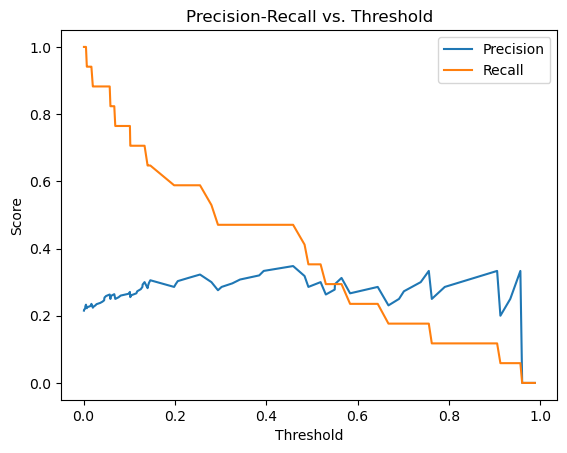

Best Threshold: 0.13360992102479913, Best F1-Score: 0.42105263157894735
Best Threshold (Youden's J): 0.13360992102479913


In [431]:
# Model 1: LogisticRegression
lr = LogisticRegression(C=1.2,max_iter=500,solver='liblinear',class_weight='balanced',random_state=42)
lr.fit(X_train_resampled, y_train_resampled)
y_probs = lr.predict_proba(X_val)[:, 1]
lr_y_pred = lr.predict(X_val)
evaluate_model(lr,y_val,lr_y_pred)
precision_recall_graph(y_probs)

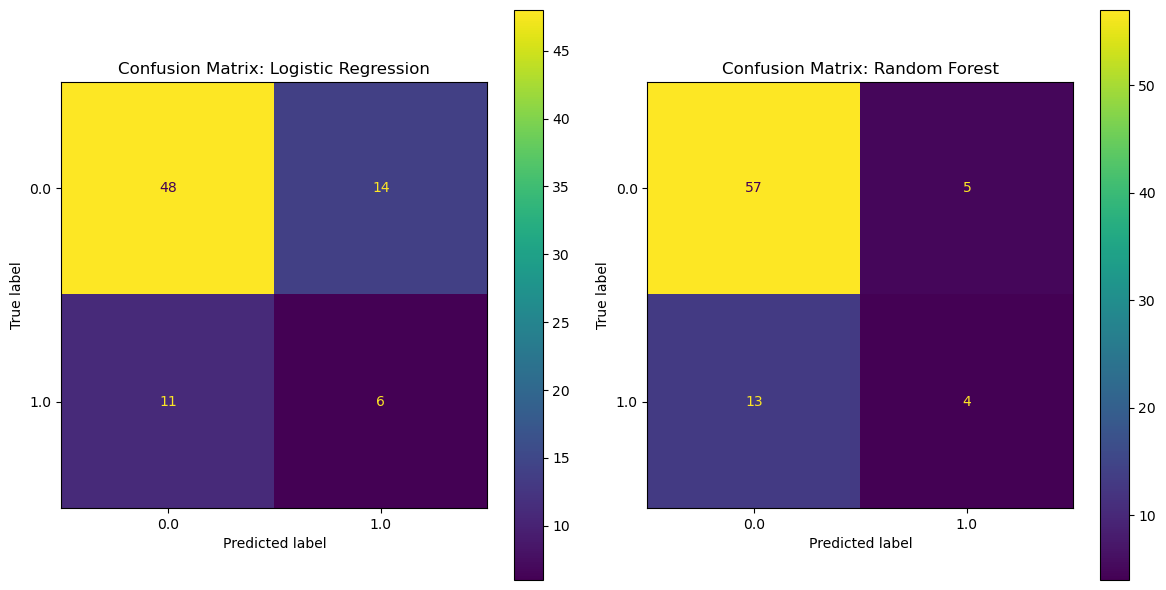

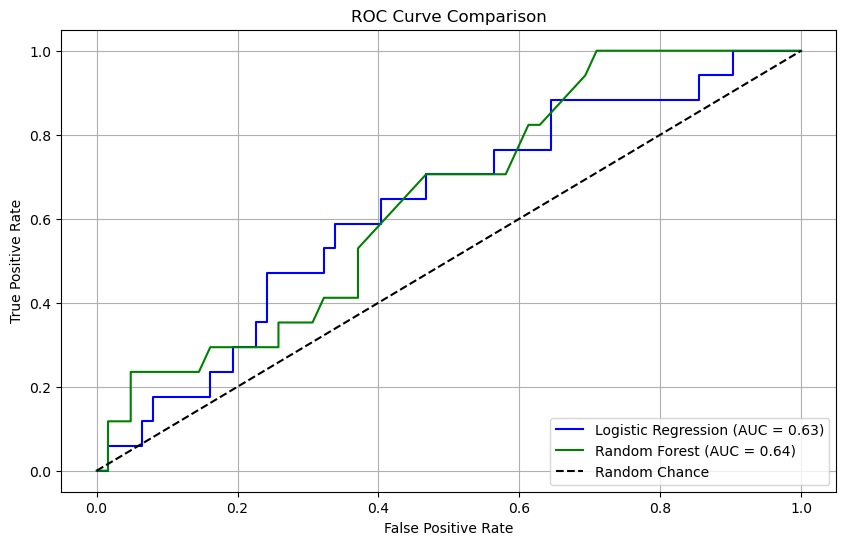

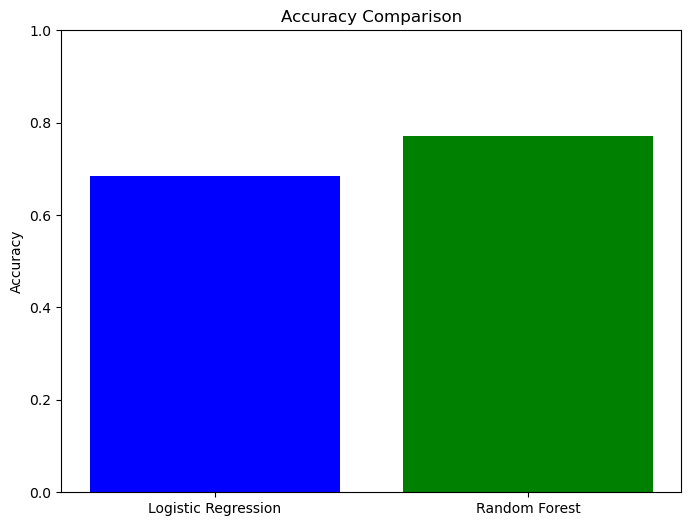

In [432]:
import matplotlib.pyplot as plt
from sklearn.metrics import auc, ConfusionMatrixDisplay, accuracy_score

# 1: Predictions and Probabilities for Logistic Regression
logistic_y_prob = baseline_lr.predict_proba(X_val)[:, 1]  # Probabilities for ROC
logistic_accuracy = accuracy_score(y_val, lr_y_pred)

# 2: Predictions and Probabilities for Random Forest
random_y_prob = baseline_rf.predict_proba(X_val)[:, 1]  # Probabilities for ROC
random_accuracy = accuracy_score(y_val, rf_y_pred)

# 3: Confusion Matrices
fig, ax = plt.subplots(1, 2, figsize=(12, 6))
ConfusionMatrixDisplay.from_predictions(y_val, lr_y_pred, ax=ax[0])
ax[0].set_title('Confusion Matrix: Logistic Regression')

ConfusionMatrixDisplay.from_predictions(y_val, rf_y_pred, ax=ax[1])
ax[1].set_title('Confusion Matrix: Random Forest')

plt.tight_layout()
plt.show()

# Step 4: ROC Curves 
logistic_fpr, logistic_tpr, _ = roc_curve(y_val, logistic_y_prob)
random_fpr, random_tpr, _ = roc_curve(y_val, random_y_prob)

logistic_auc = auc(logistic_fpr, logistic_tpr)
random_auc = auc(random_fpr, random_tpr)

plt.figure(figsize=(10, 6))
plt.plot(logistic_fpr, logistic_tpr, label=f'Logistic Regression (AUC = {logistic_auc:.2f})', color='blue')
plt.plot(random_fpr, random_tpr, label=f'Random Forest (AUC = {random_auc:.2f})', color='green')

# Diagonal for random chance
plt.plot([0, 1], [0, 1], 'k--', label='Random Chance')

# Plot settings
plt.title('ROC Curve Comparison')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.legend(loc='lower right')
plt.grid()
plt.show()

# Step 5: Bar Chart for Accuracy
plt.figure(figsize=(8, 6))
plt.bar(['Logistic Regression', 'Random Forest'], [logistic_accuracy, random_accuracy], color=['blue', 'green'])
plt.title('Accuracy Comparison')
plt.ylabel('Accuracy')
plt.ylim(0, 1)
plt.show()

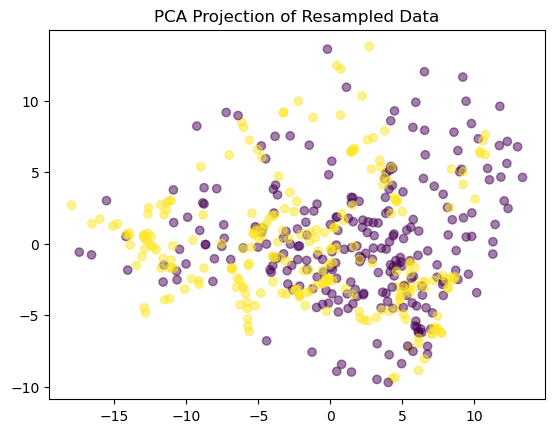

In [433]:
from sklearn.decomposition import PCA

# Data Overlapping
pca = PCA(n_components=2)
X_pca = pca.fit_transform(X_train_resampled)
plt.scatter(X_pca[:, 0], X_pca[:, 1], c=y_train_resampled, cmap='viridis', alpha=0.5)
plt.title("PCA Projection of Resampled Data")
plt.show()

<Axes: >

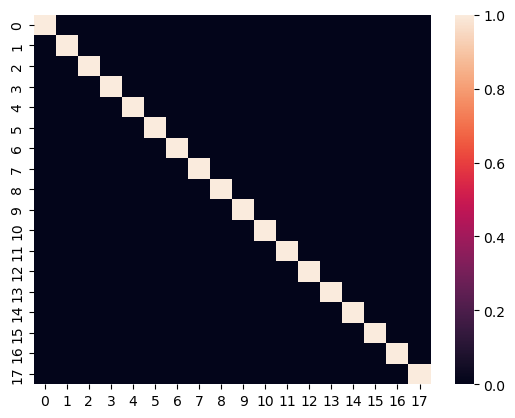

In [434]:
from sklearn.decomposition import PCA

pca = PCA(n_components = 18)
X_train_pca,X_val_pca = pca.fit_transform(X_train_resampled),pca.transform(X_val)
X_train_pca,X_val_pca = pd.DataFrame(X_train_pca),pd.DataFrame(X_val_pca)
X_train_pca.head()
sns.heatmap(X_train_pca.corr())

In [435]:
# Model 1: LogisticRegression
lr = LogisticRegression(C=1.2,max_iter=500,solver='liblinear',random_state=42)
lr.fit(X_train_pca, y_train_resampled)
y_probs = lr.predict_proba(X_val_pca)[:, 1]
y_pred = (y_probs >= 0.52).astype(int)
evaluate_model(lr,y_val,y_pred)

LogisticRegression(C=1.2, max_iter=500, random_state=42, solver='liblinear')
              precision    recall  f1-score   support

         0.0       0.89      0.76      0.82        62
         1.0       0.42      0.65      0.51        17

    accuracy                           0.73        79
   macro avg       0.65      0.70      0.66        79
weighted avg       0.79      0.73      0.75        79

Blanced Accuracy: 0.7026
Accuracy: 0.7342
Precision: 0.4231
Recall: 0.6471
F1-Score: 0.5116
ROC-AUC: 0.7026


In [436]:
# Model 1: RandomForestClassifier
rf = RandomForestClassifier(n_estimators=75,random_state=42)
rf.fit(X_train_pca, y_train_resampled)
y_probs = rf.predict_proba(X_val_pca)[:, 1]
y_pred = (y_probs >= 0.48).astype(int)
evaluate_model(rf,y_val,y_pred)

RandomForestClassifier(n_estimators=75, random_state=42)
              precision    recall  f1-score   support

         0.0       0.87      0.77      0.82        62
         1.0       0.42      0.59      0.49        17

    accuracy                           0.73        79
   macro avg       0.64      0.68      0.65        79
weighted avg       0.77      0.73      0.75        79

Blanced Accuracy: 0.6812
Accuracy: 0.7342
Precision: 0.4167
Recall: 0.5882
F1-Score: 0.4878
ROC-AUC: 0.6812


In [437]:
# Model 3: AdaBoostClassifier
from sklearn.tree import DecisionTreeClassifier


clf = AdaBoostClassifier(algorithm='SAMME',learning_rate= 0.47,n_estimators=170, random_state=42)
clf.fit(X_train_pca, y_train_resampled)
y_probs = clf.predict_proba(X_val_pca)[:, 1]
y_pred = (y_probs >= 0.51).astype(int)
evaluate_model(clf,y_val,y_pred)

AdaBoostClassifier(algorithm='SAMME', learning_rate=0.47, n_estimators=170,
                   random_state=42)
              precision    recall  f1-score   support

         0.0       0.92      0.74      0.82        62
         1.0       0.45      0.76      0.57        17

    accuracy                           0.75        79
   macro avg       0.68      0.75      0.69        79
weighted avg       0.82      0.75      0.77        79

Blanced Accuracy: 0.7533
Accuracy: 0.7468
Precision: 0.4483
Recall: 0.7647
F1-Score: 0.5652
ROC-AUC: 0.7533
